**Model 1**



In [1]:
#librosa 只有第一次需要裝

!pip install librosa==0.6.1

In [2]:
#載入所有需要的套件

import librosa
from librosa import display
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.layers.convolutional import Convolution1D
from keras.layers.normalization import BatchNormalization
from keras import initializers

%matplotlib inline

#config 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

model_name = 'Model_3_final.h5'
save_dir = 'Ravdess_model'

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 進行建模事前準備
## 設定檔

In [3]:
path = '../../dataset/ravdess_datasets/audio/'
lst = []
save_dir = 'joblib'
load_raw_data = False
load_raw_test_data = False

##  讀資料

In [4]:
if load_raw_data:
    total_file = 0
    start_time = time.time()
    print("--- Start load Data. Start time: %s ---" % (start_time))
    for subdir, dirs, files in os.walk(path):

        for file in files:
            try:
                #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
                X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
                # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
                # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
                file = int(file[7:8]) - 1 
                arr = mfccs, file
                lst.append(arr)
                total_file += 1
              # If the file is not valid, skip it
            except ValueError:
                continue

    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
    print(f"total file: {total_file}")

In [5]:
if load_raw_data:
    # Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
    X, y = zip(*lst)

In [6]:
if load_raw_data:
    X = np.asarray(X)
    y = np.asarray(y)
    X.shape, y.shape

In [7]:
if load_raw_data:
    # Saving joblib files to not load them again with the loop above
    X_name = 'X_full_mfcc_40_fast.joblib'
    y_name = 'y_full_mfcc_40_fast.joblib'
    savedX = joblib.dump(X, os.path.join(save_dir, X_name))
    savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [8]:
# Loading saved models
X = joblib.load(f'{save_dir}/X_full_mfcc_100_fast.joblib')
y = joblib.load(f'{save_dir}/y_full_mfcc_100_fast.joblib')

##  切分訓練與測試資料

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 模型3: Neural network

In [10]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [11]:
x_traincnn.shape, x_testcnn.shape

((3756, 100, 1), (940, 100, 1))

In [12]:
model = Sequential()
learning_rate = 0.0005
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

initial = initializers.he_normal()

model.add(Conv1D(128, 5,padding='same',kernel_initializer=initial, input_shape=(100,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',kernel_initializer=initial))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 5,padding='same',kernel_initializer=initial,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',kernel_initializer=initial,))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(8,))
model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 128)          768       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          82048     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)          

In [14]:
def schedule(epoch):  # 定義 learning rate 根據 epoch 要如何變動
    if epoch < 50:
        return 0.9
    elif epoch < 100:
        return 0.5
    elif epoch < 200:
        return 0.05
    elif epoch < 300:
        return 0.005
    elif epoch < 400:
        return 0.0005
    elif epoch < 500:
        return 0.00005
    else:
        return 0.000005

In [15]:
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
def get_callbacks_list(model):
    logfiles = model_dir + '/{}-{}'.format('basic_model',model.__class__.__name__)
    model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,histogram_freq=1)

    modelfiles = model_dir + '/{}-best-model-3.h5'.format('basic_model')
    model_mckp = keras.callbacks.ModelCheckpoint(
        modelfiles,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1)
    
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=50)

    lr_schedule = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
#     callbacks_list = [model_cbk, model_mckp]
    
#     callbacks_list = [model_cbk, model_mckp, lr_schedule, es]
    callbacks_list = [model_cbk, model_mckp, es]
    return callbacks_list

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=300, epochs=1000, validation_data=(x_testcnn, y_test),callbacks=get_callbacks_list(model))

Train on 3756 samples, validate on 940 samples
Epoch 1/1000
3300/3756 [=========================>....] - ETA: 0s - loss: 2.4573 - accuracy: 0.1670

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.345346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.338885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3756/3756 [==============================] - 4s 1ms/step - loss: 2.4398 - accuracy: 0.1701 - val_loss: 5.0253 - val_accuracy: 0.0734

Epoch 00001: val_loss improved from inf to 5.02526, saving model to ./Model/model-logs/basic_model-best-model-3.h5
Epoch 2/1000
3756/3756 [==============================] - 0s 52us/step - loss: 2.2168 - accuracy: 0.1672 - val_loss: 3.2195 - val_accuracy: 0.1277

Epoch 00002: val_loss improved from 5.02526 to 3.21951, saving model to ./Model/model-logs/basic_model-best-model-3.h5
Epoch 3/1000
3756/3756 [==============================] - 0s 50us/step - loss: 2.1126 - accuracy: 0.1430 - val_loss: 2.6546 - val_accuracy: 0.1521

Epoch 00003: val_loss improved from 3.21951 to 2.65458, saving model to ./Model/model-logs/basic_model-best-model-3.h5
Epoch 4/1000
3756/3756 [==============================] - 0s 50us/step - loss: 2.0534 - accuracy: 0.1712 - val_loss: 2.4215 - val_accuracy: 0.1511

Epoch 00004: val_loss improved from 2.65458 to 2.42147, saving model 

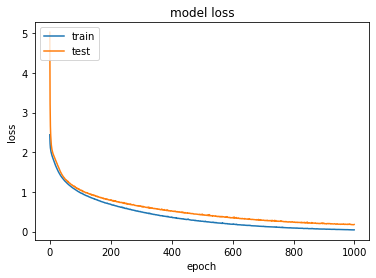

In [18]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

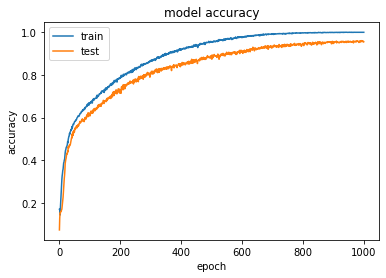

In [19]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
predictions = model.predict_classes(x_testcnn)

In [21]:
new_Ytest = y_test.astype(int)

In [22]:
report = classification_report(new_Ytest, predictions)

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        64
           1       0.95      0.98      0.97       142
           2       0.99      0.92      0.95       149
           3       0.96      0.93      0.94       163
           4       0.97      0.98      0.98       153
           5       0.96      0.98      0.97       149
           6       0.89      0.98      0.94        52
           7       0.87      0.96      0.91        68

    accuracy                           0.96       940
   macro avg       0.95      0.95      0.95       940
weighted avg       0.96      0.96      0.96       940



In [24]:
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[ 58   0   0   2   0   0   2   2]
 [  0 139   0   3   0   0   0   0]
 [  0   2 137   0   4   2   0   4]
 [  0   5   0 152   0   3   2   1]
 [  0   0   0   0 150   1   0   2]
 [  1   0   1   1   0 146   0   0]
 [  0   0   0   0   0   0  51   1]
 [  0   0   0   1   0   0   2  65]]


In [25]:
loaded_model = keras.models.load_model('./Model/model-logs/basic_model-best-model-3.h5')
# loaded_model = keras.models.load_model('./Model/Emotion_Voice_Detection_Model.h5')

In [26]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {:5.2f}%".format(100*loss))

940/940 [==============================] - 0s 254us/step
Restored model, accuracy: 95.64%
Restored model, loss: 17.16%


In [27]:
if load_raw_test_data:
    for mfcc in [100]: 
        path = '../../dataset/final_test_datasaet_model1/audio'
        test_lst = []
        start_time = time.time()
        print(f"--- mfcc:{mfcc} Start load Data. Start")
        for subdir, dirs, files in os.walk(path):
            for file in files:
                try:
                    #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
                    test_X, test_sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
                    test_mfccs = np.mean(librosa.feature.mfcc(y=test_X, sr=test_sample_rate, n_mfcc=mfcc).T,axis=0) 

                    # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
                    # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
                    test_file = int(file[7:8]) - 1 
                    test_arr = test_mfccs, test_file
                    test_lst.append(test_arr)
                  # If the file is not valid, skip it
                except ValueError:
                    continue

        print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

        test_X, test_y = zip(*test_lst)
        test_X = np.asarray(test_X)
        test_y = np.asarray(test_y)
        test_X_name = 'test_X_mfcc_100_fast.joblib'
        test_y_name = 'test_y_mfcc_100_fast.joblib'
        test_savedX = joblib.dump(test_X, os.path.join(save_dir, test_X_name))
        test_savedy = joblib.dump(test_y, os.path.join(save_dir, test_y_name))



In [28]:
# Loading saved models
test_X = joblib.load(f'{save_dir}/test_X_mfcc_100_fast.joblib')
test_y = joblib.load(f'{save_dir}/test_y_mfcc_100_fast.joblib')
test_x = np.expand_dims(test_X, axis=2)
test_y = np.expand_dims(test_y, axis=2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [29]:
test_loss, test_acc = loaded_model.evaluate(test_x, test_y)
print("Restored model, accuracy: {:5.2f}%".format(100*test_acc))
print("Restored model, loss: {:5.2f}%".format(100*test_loss))
test_predictions = loaded_model.predict_classes(test_x)
test_new_Ytest = test_y.astype(int)
test_report = classification_report(test_new_Ytest, test_predictions)
print(test_report)

208/208 [==============================] - 0s 256us/step
Restored model, accuracy: 92.31%
Restored model, loss: 23.61%
              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.94      0.97      0.95        32
           2       0.97      0.97      0.97        32
           3       0.85      0.91      0.88        32
           4       1.00      0.97      0.98        32
           5       0.93      0.88      0.90        32
           6       1.00      0.88      0.93        16
           7       0.76      1.00      0.86        16

    accuracy                           0.92       208
   macro avg       0.92      0.91      0.91       208
weighted avg       0.93      0.92      0.92       208



In [30]:
matrix = confusion_matrix(test_new_Ytest, test_predictions)
print (matrix)

[[12  1  0  1  0  0  0  2]
 [ 0 31  0  1  0  0  0  0]
 [ 0  0 31  0  0  0  0  1]
 [ 0  1  0 29  0  1  0  1]
 [ 0  0  0  0 31  1  0  0]
 [ 1  0  1  2  0 28  0  0]
 [ 0  0  0  1  0  0 14  1]
 [ 0  0  0  0  0  0  0 16]]
